## Neural networks for approximating functions
This notebook is intended as a practice ground to learn how to use neural networks for approximating functions, are NNs are universal.

In [26]:
# import libraries
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import r2_score

In [27]:
# define function(s)
f_poly = lambda x: 3*x**3*np.sin(x) + 2*x**2 + x
f_sin = lambda x: np.sin(x)
f_abs = lambda x: abs(x)

In [28]:
# create training and test set with the function
function = f_sin
n_samples = 1000
x_min = -10
x_max = 10
collocation_points = np.linspace(x_min, x_max, num=n_samples)

samples = np.empty([n_samples, 2])
for i, x in enumerate(collocation_points):
    samples[i, 0] = x
    samples[i, 1] = function(x)
np.random.shuffle(samples) # Shuffle the samples in-place
split_index = int(n_samples * 0.8) # define train/test split
train_x_np = samples[:split_index, 0]
train_y_np = samples[:split_index, 1]
test_x_np = samples[split_index:, 0]
test_y_np = samples[split_index:, 1]

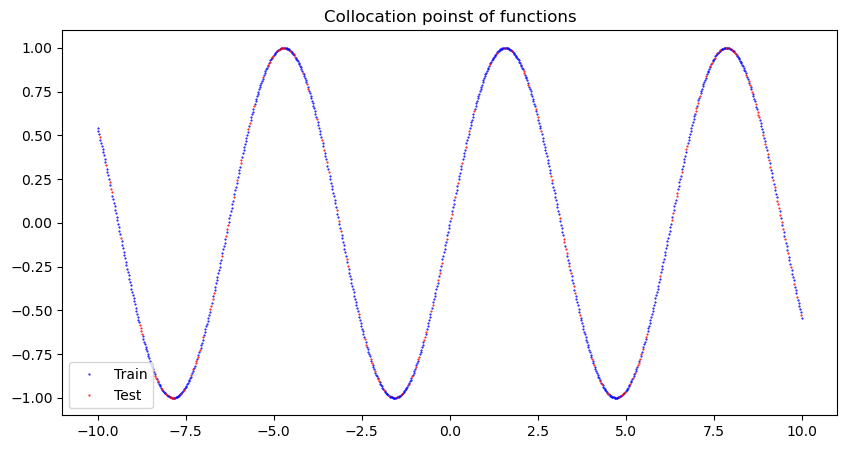

In [29]:
# plot training and test set
plt.figure(figsize=(10, 5))
plt.plot(train_x_np, train_y_np, color = "blue", marker='o', linestyle='none', markersize=0.5)
plt.plot(test_x_np, test_y_np, color = "red", marker='o', linestyle='none', markersize=0.5)
plt.title("Collocation poinst of functions")
plt.legend(["Train", "Test"], loc="lower left")

In [30]:
#Change numpy array to tensor
train_x = torch.from_numpy(train_x_np).unsqueeze(1).float()
train_y = torch.from_numpy(train_y_np).unsqueeze(1).float()
test_x = torch.from_numpy(test_x_np).unsqueeze(1).float()
test_y = torch.from_numpy(test_y_np).unsqueeze(1).float()

In [31]:
# define network architecture
input_dim = 1
output_dim = 1
num_hidden = 300

class Net(nn.Module):
    def __init__(self, num_hidden):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, output_dim),
        )

    def forward(self, x):
        y_out = self.linear_relu_stack(x)
        return y_out
    
net = Net(num_hidden)
    
# hyperparameters
learning_rate = 1e-5
batch_size = 50
num_epochs = 2000

#loss
loss_fn = nn.MSELoss()

#optimizer
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

Epoch  1 : Train Loss 0.189588 , Train r2 -0.040551, Test r2 -0.033192
Epoch 51 : Train Loss 0.115327 , Train r2 0.249537, Test r2 0.200087
Epoch 101 : Train Loss 0.095576 , Train r2 0.378503, Test r2 0.316409
Epoch 151 : Train Loss 0.079864 , Train r2 0.480955, Test r2 0.414147
Epoch 201 : Train Loss 0.068727 , Train r2 0.553587, Test r2 0.485341
Epoch 251 : Train Loss 0.061473 , Train r2 0.600892, Test r2 0.532577
Epoch 301 : Train Loss 0.056979 , Train r2 0.630229, Test r2 0.562637
Epoch 351 : Train Loss 0.054156 , Train r2 0.648650, Test r2 0.581990
Epoch 401 : Train Loss 0.052250 , Train r2 0.661101, Test r2 0.595442
Epoch 451 : Train Loss 0.050821 , Train r2 0.670438, Test r2 0.605935
Epoch 501 : Train Loss 0.049623 , Train r2 0.678251, Test r2 0.615079
Epoch 551 : Train Loss 0.048511 , Train r2 0.685505, Test r2 0.623690
Epoch 601 : Train Loss 0.047416 , Train r2 0.692645, Test r2 0.632268
Epoch 651 : Train Loss 0.046311 , Train r2 0.699866, Test r2 0.640991
Epoch 701 : Train Lo

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'R2'))

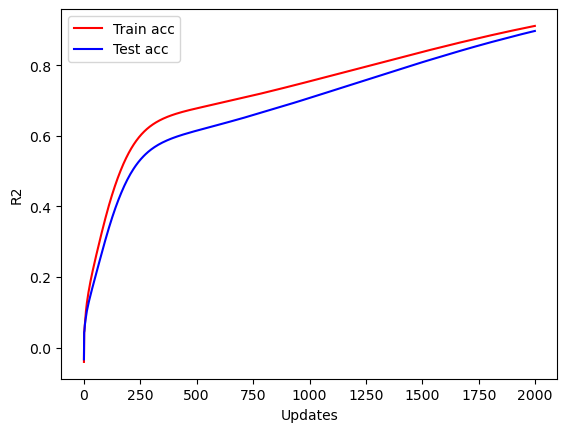

In [32]:
# train network

#getting epoch sizes
num_samples_train = train_x.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_test = test_x.shape[0]
num_batches_test = num_samples_test // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size) #get slices for each batch

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        optimizer.zero_grad()
        slce = get_slice(i, batch_size)
        output = net(train_x[slce])

        # compute gradients given loss
        y_batch = train_y[slce]
        batch_loss = loss_fn(output, y_batch)
        batch_loss.backward()
        optimizer.step()

        cur_loss += batch_loss
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        output = net(train_x[slce])

        preds = output.squeeze(1)

        train_targs += list(train_y[slce].numpy())
        train_preds += list(preds.data.numpy())

    ### Evaluate test
    test_preds, test_targs = [], []
    for i in range(num_batches_test):
        slce = get_slice(i, batch_size)

        output = net(test_x[slce])
        preds = output.squeeze(1)
        test_targs += list(test_y[slce].numpy())
        test_preds += list(preds.data.numpy())


    train_r2 = r2_score(train_targs, train_preds)
    test_r2 = r2_score(test_targs, test_preds)

    train_acc.append(train_r2)
    test_acc.append(test_r2)

    if epoch % 50 == 0:
        print("Epoch %2i : Train Loss %f , Train r2 %f, Test r2 %f" % (
                epoch+1, losses[-1], train_r2, test_r2))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, test_acc, 'b')
plt.legend(['Train acc','Test acc'])
plt.xlabel('Updates'), plt.ylabel('R2')

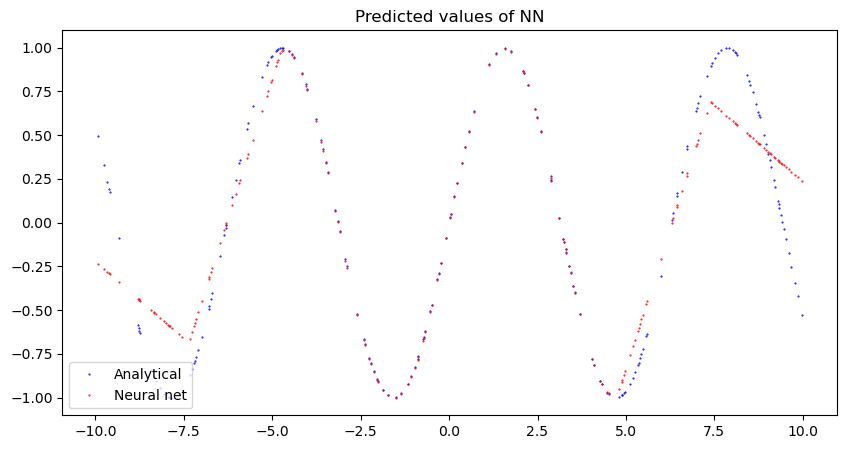

In [33]:
 # evaluate network at different points, show results
test_y_eval = net(test_x) #predictes y values of test set of the trained model
test_y_eval_np = test_y_eval.detach().numpy() #converts it to numpy array

# plot analytical solution vs predicted values of test set
plt.figure(figsize=(10, 5))
plt.plot(test_x_np, test_y_np, color = "blue", marker='o', linestyle='none', markersize=0.5)
plt.plot(test_x_np, test_y_eval_np, color = "red", marker='o', linestyle='none', markersize=0.5)
plt.title("Predicted values of NN")
plt.legend(["Analytical", "Neural net"], loc="lower left")